In [1]:
import pandas as pd
import numpy as np
import re, random
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline

import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import datasets 
import evaluate


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

#torch.cuda.empty_cache()

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
print(torch.__version__)

2.5.1+cu124


# Load data

In [4]:
data_train = pd.read_csv('./data/my_train.csv') 
data_test = pd.read_csv('./data/my_test.csv')
data_val= pd.read_csv('./data/my_val.csv')

In [5]:
data_train.head(2)

,Unnamed: 0,sentiment,text
0,12588,1,two rooms packed and cleaned three to go
1,1079,0,_nation just launched twittix v1 10 not convinced


In [6]:
# remove Unnamed:0 and use label instead of sentiment
train_df = pd.DataFrame({
    "label": data_train.sentiment.values,
    "text": data_train.text.values
})

val_df = pd.DataFrame({
    "label": data_val.sentiment.values,
    "text": data_val.text.values
})

test_df = pd.DataFrame({
    "label": data_test.sentiment.values,
    "text": data_test.text.values
})

## Create Dataset objects

In [7]:
# create DATASETs

train_df = datasets.Dataset.from_dict(train_df)
val_df = datasets.Dataset.from_dict(val_df)
test_df = datasets.Dataset.from_dict(test_df)

In [8]:
# Create DATASET DICT
dataset_dict = datasets.DatasetDict({"train":train_df, "valid":val_df, "test":test_df})

In [9]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 18968
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2108
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5270
    })
})

# XlNET
Using [xlnet base-size model](https://huggingface.co/xlnet/xlnet-base-cased) on Hugging Face

## Why I choose XLNet?

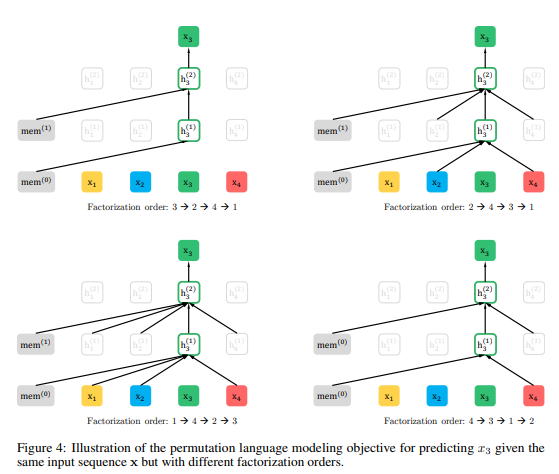


| GPT | BERT | XLNET|
|-|-|-|
| Auto-regressive models| Masked Language Model (Bidirectional understanding context )| Permutation-based models|
| Try to predict **the next word** (from lefto to right)| some words in a sentence are **randomly masked** and the model's task is to predict the masked words based on the surrounding context| can consider ALL words, not just the words to right and left of the target. It samples different permutation of the input data. **Learns to predict the probability of each word given the entire context.**

- **Key innovation**: it overcomes some of the limitations of previous models in terms of how processes text to get a *deeper understanding of context*

- **LLM developed by** Google AI and Carnagie Mellon University in 2019
    - *BASE*: 110M parameters (12 layers of decoders)
    - *LARGE*: 340M parameters (24 layers of decoders)


In [10]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [11]:
#we want to return our tokenizer over our examples text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [12]:
# we can apply tokenize function over our dataset dictionary
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/18968 [00:00<?, ? examples/s]

Map:   0%|          | 0/2108 [00:00<?, ? examples/s]

Map:   0%|          | 0/5270 [00:00<?, ? examples/s]

In [13]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18968
    })
    valid: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2108
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5270
    })
})

In [14]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(9000))
small_eval_dataset = tokenized_datasets["valid"].shuffle(seed=42).select(range(1000))

# Fine Tune our model

In [15]:
NUM_LABELS = 3
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', 
                                                       num_labels = NUM_LABELS, 
                                                       id2label = {0: 'negative', 1: 'neutral', 2: 'positive'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
metric = evaluate.load("accuracy")

In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

In [18]:
training_args = TrainingArguments(output_dir = "test_trainer", eval_strategy = "epoch", num_train_epochs = 3)

In [19]:
trainer = Trainer(
    model = model, 
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["valid"],
    compute_metrics = compute_metrics)

In [20]:
trainer.train()

  0%|          | 0/7113 [00:00<?, ?it/s]

{'loss': 0.8581, 'grad_norm': 11.75599479675293, 'learning_rate': 4.6485308589905805e-05, 'epoch': 0.21}
{'loss': 0.71, 'grad_norm': 6.990516662597656, 'learning_rate': 4.2970617179811615e-05, 'epoch': 0.42}
{'loss': 0.7059, 'grad_norm': 3.8654518127441406, 'learning_rate': 3.9455925769717424e-05, 'epoch': 0.63}
{'loss': 0.733, 'grad_norm': 6.610783576965332, 'learning_rate': 3.594123435962323e-05, 'epoch': 0.84}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 0.6728677749633789, 'eval_accuracy': 0.7523719165085389, 'eval_runtime': 27.5361, 'eval_samples_per_second': 76.554, 'eval_steps_per_second': 9.587, 'epoch': 1.0}
{'loss': 0.7072, 'grad_norm': 6.29326868057251, 'learning_rate': 3.242654294952903e-05, 'epoch': 1.05}
{'loss': 0.6265, 'grad_norm': 6.609657287597656, 'learning_rate': 2.8911851539434836e-05, 'epoch': 1.27}
{'loss': 0.6221, 'grad_norm': 10.940587043762207, 'learning_rate': 2.5397160129340646e-05, 'epoch': 1.48}
{'loss': 0.596, 'grad_norm': 16.21500015258789, 'learning_rate': 2.1882468719246452e-05, 'epoch': 1.69}
{'loss': 0.5795, 'grad_norm': 7.635183811187744, 'learning_rate': 1.8367777309152258e-05, 'epoch': 1.9}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 0.6260012984275818, 'eval_accuracy': 0.7722960151802657, 'eval_runtime': 27.6876, 'eval_samples_per_second': 76.135, 'eval_steps_per_second': 9.535, 'epoch': 2.0}
{'loss': 0.5285, 'grad_norm': 8.496991157531738, 'learning_rate': 1.4853085899058064e-05, 'epoch': 2.11}
{'loss': 0.4985, 'grad_norm': 14.164031982421875, 'learning_rate': 1.133839448896387e-05, 'epoch': 2.32}
{'loss': 0.4749, 'grad_norm': 8.00275993347168, 'learning_rate': 7.823703078869675e-06, 'epoch': 2.53}
{'loss': 0.454, 'grad_norm': 15.183998107910156, 'learning_rate': 4.309011668775482e-06, 'epoch': 2.74}
{'loss': 0.4601, 'grad_norm': 21.705570220947266, 'learning_rate': 7.943202586812878e-07, 'epoch': 2.95}


  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 0.6342470049858093, 'eval_accuracy': 0.7884250474383302, 'eval_runtime': 30.2139, 'eval_samples_per_second': 69.769, 'eval_steps_per_second': 8.738, 'epoch': 3.0}
{'train_runtime': 2139.3449, 'train_samples_per_second': 26.599, 'train_steps_per_second': 3.325, 'train_loss': 0.6092899150357675, 'epoch': 3.0}


TrainOutput(global_step=7113, training_loss=0.6092899150357675, metrics={'train_runtime': 2139.3449, 'train_samples_per_second': 26.599, 'train_steps_per_second': 3.325, 'total_flos': 4052740463953920.0, 'train_loss': 0.6092899150357675, 'epoch': 3.0})

# Evaluate the model

In [21]:
trainer.evaluate()

  0%|          | 0/264 [00:00<?, ?it/s]

{'eval_loss': 0.6342470049858093,
 'eval_accuracy': 0.7884250474383302,
 'eval_runtime': 30.2396,
 'eval_samples_per_second': 69.71,
 'eval_steps_per_second': 8.73,
 'epoch': 3.0}

# Save our model

In [22]:
model.save_pretrained("fine_tuned_model_xlnet_sentiment3")

In [23]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model_xlnet_sentiment3")

In [24]:
trainer = Trainer(
    model = fine_tuned_model)
predictions= trainer.predict(tokenized_datasets['test'])

  0%|          | 0/659 [00:00<?, ?it/s]

In [25]:
probabilities = predictions.predictions
# Get the predicted class ID (index of the highest probability)
predicted_class_ids = np.argmax(probabilities, axis=-1)
predicted_class_ids

array([0, 0, 2, ..., 1, 1, 2])

# See the metrics

In [26]:
accuracy = accuracy_score(data_test['sentiment'], predicted_class_ids)
round(accuracy,3)

0.798

Classification_report
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1792
           1       0.72      0.72      0.72      1731
           2       0.85      0.83      0.84      1747

    accuracy                           0.80      5270
   macro avg       0.80      0.80      0.80      5270
weighted avg       0.80      0.80      0.80      5270

Confusion Matrix


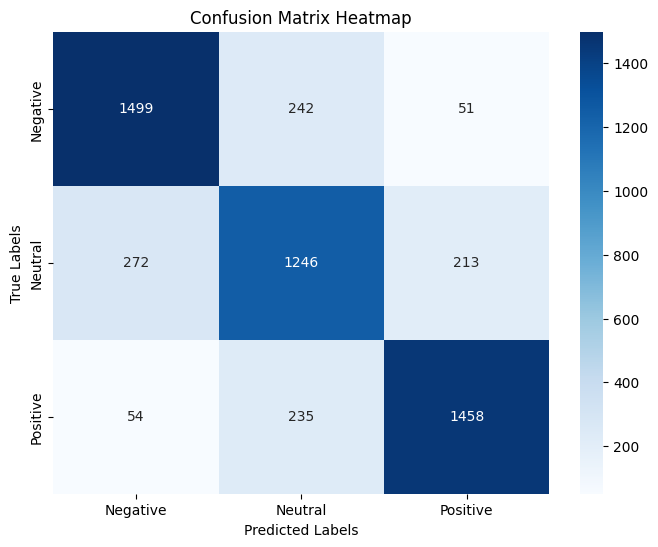

In [28]:
y_test, y_pred= data_test['sentiment'],  predicted_class_ids

accuracy_score(y_test,y_pred)
print(f'Classification_report')
print(classification_report(y_test,y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Bibliography

[XLNet: Generalized Autoregressive Pretraining for Language Understanding,Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le,2019](https://arxiv.org/pdf/1906.08237)
